# Important Library Imports

In [22]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset
import math
from torchvision.utils import make_grid
import time
import pickle

# Helper Functions

In [37]:
def validate_model(model, val_loader, device):
    with torch.no_grad():
        num_correct = 0
        total = 0
        model.eval()
        for batch, labels in val_loader:
            batch = batch.to(device)
            labels = labels.to(device)

            pred = model(batch)
            num_correct += (pred.argmax(dim=1) == labels).type(torch.float).sum().item()
            total += len(labels)
        accuracy = (num_correct / total) * 100
        return accuracy

def test_model(model, test_loader, device):
    with torch.no_grad():
        num_correct = 0
        total = 0
        model.eval()
        for batch, labels in test_loader:
            batch = batch.to(device)
            labels = labels.to(device)

            pred = model(batch)
            num_correct += (pred.argmax(dim=1) == labels).type(torch.float).sum().item()
            total += len(labels)
        accuracy = (num_correct / total) * 100
        return accuracy

def train_model(model, train_loader, val_loader, device):
    NUM_EPOCHS = 3
    learning_rate = 0.0001
    adam_beta1 = 0.9
    adam_beta2 = 0.999

    model.train()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, betas=(adam_beta1, adam_beta2))
    criterion = nn.CrossEntropyLoss()

    epoch_loss = []
    validaction_acc = []
    train_acc = []

    start_time = time.time()

    for epoch in range(NUM_EPOCHS):
        model.train()
        train_loss = []
        print("Epoch %d" % epoch)
        for batch, labels in train_loader:
            batch = batch.to(device)
            labels = labels.to(device)

            pred = model(batch)

            optimizer.zero_grad()
            loss = criterion(pred, labels)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
        ##################################################

        # Track average loss for each epoch
        epoch_loss.append(sum(train_loss) / len(train_loss))
        train_acc.append(test_model(model, train_loader, device))

        validation_accuracy = validate_model(model=model, val_loader=val_loader, device=device)
        validaction_acc.append(validation_accuracy)

    end_time = time.time()
    total_time = end_time - start_time

    return epoch_loss, train_loss, validaction_acc, total_time, train_acc

# Load Dataset

In [38]:
# Create Data Augmentation
data_transforms = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomApply([
            transforms.ElasticTransform(alpha=40.0, sigma=8.0)
        ], p=0.2),
        transforms.RandomApply([
            transforms.RandomAffine(degrees=0, shear=20, fill=255)
        ], p=0.2),
        transforms.RandomApply([
            transforms.RandomAffine(degrees=0, scale=(0.8, 1.2), fill=255)
        ], p=0.2),
        transforms.RandomApply([
            transforms.RandomHorizontalFlip(p=1.0)
        ], p=0.2),
        transforms.RandomApply([
            transforms.RandomVerticalFlip(p=1.0)
        ], p=0.2),
    ]),
    transforms.ToTensor()
])

# Load Training, Validation, and Testing Images
LABELS = ["Apple Scab", "Apple Black Rot", "Apple Cedar Rust", "Apple Healthy", "Blueberry Healthy", "Cherry Healthy", "Cherry Powdery Mildew", "Corn Cercospora Leaf Spot", "Corn Common Rust", "Corn Healthy", "Corn Northern Leaf Blight", "Grape Black Rot", "Grape Black Measles", "Grape Healthy", "Grape Isariopsis Leaf Spot", "Orange Haunglonbing",
          "Peach Bacterial Spot", "Peach Healthy", "Bell Pepper Bacterial Spot", "Bell Pepper Healthy", "Potato Early Blight", "Potato Healthy", "Potato Late Blight", "Raspberry Healthy", "Soybean Healthy", "Squash Powdery Mildew", "Strawberry Healthy", "Strawberry Leaf Scorch", "Tomato Bacterial Spot", "Tomato Early Blight", "Tomato Healthy",
          "Tomato Late Blight", "Tomato Leaf Mold", "Tomato Septoria Leaf Spot", "Tomato Spider Mites", "Tomato Target Spot", "Tomato Mosaic Virus", "Tomato Yellow Leaf Curl Virus"]

BATCH_SIZE = 128
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Running on {DEVICE}")
folder_path = "PlantVillage"

train_set = ImageFolder(root=folder_path + "\Training", transform=data_transforms)
val_set = ImageFolder(root=folder_path + "\Validation", transform=transforms.ToTensor())
test_set = ImageFolder(root=folder_path + "\Testing", transform=transforms.ToTensor())

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=12)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Running on cuda


# Load Pretrained Backbones

In [34]:
DEVICE = torch.device("cuda")
# Load all backbones
resnet101 = torchvision.models.resnet101(weights=torchvision.models.ResNet101_Weights.DEFAULT).to(device=DEVICE)
resnet50 = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT).to(device=DEVICE)
efficientnetb0 = torchvision.models.efficientnet_b0(weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT).to(device=DEVICE)
efficientnetb1 = torchvision.models.efficientnet_b1(weights=torchvision.models.EfficientNet_B1_Weights.DEFAULT).to(device=DEVICE)
efficientnetb2 = torchvision.models.efficientnet_b2(weights=torchvision.models.EfficientNet_B2_Weights.DEFAULT).to(device=DEVICE)
efficientnetb3 = torchvision.models.efficientnet_b3(weights=torchvision.models.EfficientNet_B3_Weights.DEFAULT).to(device=DEVICE)
densenet121 = torchvision.models.densenet121(weights=torchvision.models.DenseNet121_Weights.DEFAULT).to(device=DEVICE)

# Remove last layer for each backbone
resnet101.fc = nn.Identity()
resnet50.fc = nn.Identity()
efficientnetb0.classifier[1] = nn.Identity()
efficientnetb1.classifier[1] = nn.Identity()
efficientnetb2.classifier[1] = nn.Identity()
efficientnetb3.classifier[1] = nn.Identity()
densenet121.classifier = nn.Identity()

# Prep list of model and output size
backbones = [("resnet101", resnet101, 2048), ("resnet50", resnet50, 2048), ("efficientnetb0", efficientnetb0, 1280), ("efficientnetb1", efficientnetb1, 1280), ("efficientnetb2", efficientnetb2, 1280), ("efficientnetb3", efficientnetb3, 1536), ("densenet121", densenet121, 1024)]
# backbones = [("resnet50", resnet50, 2048), ("efficientnetb0", efficientnetb0, 1280), ("efficientnetb1", efficientnetb1, 1280), ("efficientnetb2", efficientnetb2, 1280), ("efficientnetb3", efficientnetb3, 1536), ("densenet121", densenet121, 1024)]


# Benchmark Each Backbone

In [26]:
NUM_CLASSES = 38
for name, backbone, backbone_output_size in backbones:
    benchmarks = {}
    print(name)
    # Freeze backbone parameters
    for param in backbone.parameters():
        param.requires_grad = False
    # Create model
    model = nn.Sequential(backbone, nn.Linear(backbone_output_size, NUM_CLASSES, device=DEVICE), nn.Softmax(dim=1)).to(DEVICE)
    epoch_loss, train_loss, val_acc, train_time, train_acc = train_model(model, train_loader, val_loader, DEVICE)
    # Test model
    model.eval()
    test_acc = test_model(model, test_loader, DEVICE)
    benchmarks[name] = (epoch_loss, train_loss, val_acc, test_acc, train_time, train_acc)

    # Save benchmark information
    file_path = "benchmarks/benchmarks_" + name + ".pickle"
    with open(file_path, "wb") as file:
        pickle.dump(benchmarks, file)



resnet50
Epoch 0
Epoch 1
Epoch 2
efficientnetb0
Epoch 0


KeyboardInterrupt: 

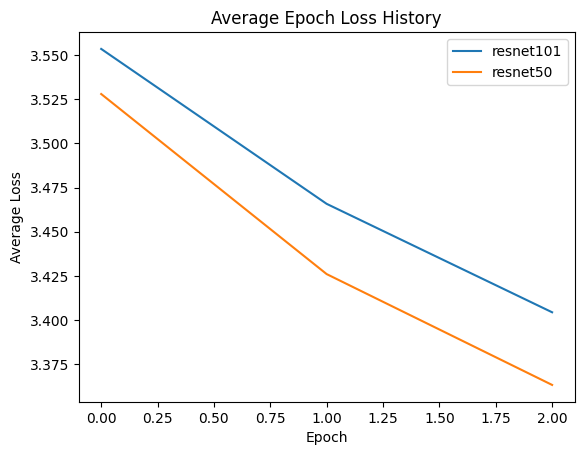

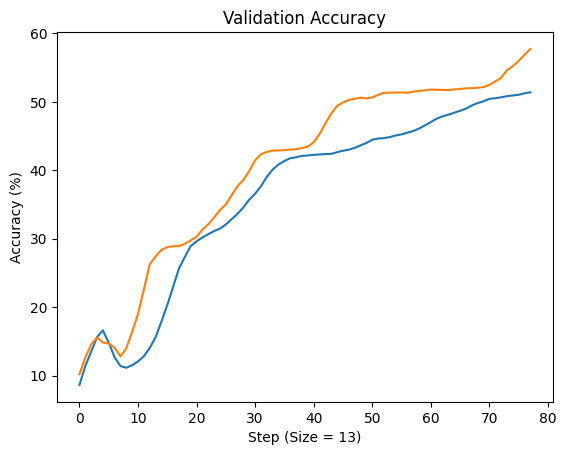

In [36]:
# Load benchmark information
contents = {}
for val in backbones[:2]:
    file_path = "benchmarks/benchmarks_" + val[0] + ".pickle"
    with open(file_path, "rb") as file:
        loaded = pickle.load(file)
        contents[val[0]] = loaded[val[0]]


plt.title("Average Epoch Loss History")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
for key in contents:
    plt.plot(contents[key][0], label=key)
plt.legend()
plt.show()

plt.title("Validation Accuracy")
plt.xlabel("Step (Size = 13)")
plt.ylabel("Accuracy (%)")
for key in contents:
    plt.plot(contents[key][2], label=key)
plt.show()

# print("Resnet101 test accuracy %f%%" % loaded_benchmarks["resnet101"][3])
# print("Resnet101 training time %fmins" % (loaded_benchmarks["resnet101"][4] / 60))